In [127]:
import numpy as np
import cmath
import math
from multipledispatch import dispatch
import time
from scipy.optimize import minimize
from scipy.optimize import root
import random
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import time

In [128]:
def create_phase_matrix(n, phase):
    phase_matrix = np.eye(n, dtype = complex)
    for i in range(n-1):
        for j in range(n-1):
            if (i==j):
                phase_matrix[i][j] = cmath.exp(1j*phase[i])
    return phase_matrix

def Theta_0_5_0_8(m):
    _Theta = []
    dif = (math.asin(2/math.sqrt(5)) - math.pi/4)/m
    for i in range(m):
        _Theta.append(math.pi/4 + i*dif)
    return _Theta


def ET_v_matrices(n, theta, phis, errors):
    _V_matrices_product = np.eye(n, dtype=complex)
    for _i in range(2 * n):  # i is a number of a layer
        _j = _i % 2  # j - even or odd layer
        _V = np.eye(n, dtype=complex)
        while _j < n - 1:  # j became channel number
            _T = np.eye(n, dtype=complex)
            _T[_j][_j] = cmath.exp(1j * phis[_i]) * cmath.cos(theta + errors[_i])
            _T[_j][_j + 1] = cmath.sin(theta + errors[_i])
            _T[_j + 1][_j] = -cmath.exp(1j * phis[_i]) * cmath.sin(theta + errors[_i])
            _T[_j + 1][_j + 1] = cmath.cos(theta + errors[_i])
            _V = np.dot(_V, _T)
            _j += 2
        _V_matrices_product = np.dot(_V, _V_matrices_product)
    del _i, _j, _T, _V
    return _V_matrices_product


def Cl_v_matrices(n, theta, phis, errors):
    _V_matrices_product = np.eye(n, dtype=complex)
    for _i in range(2 * n):  # i is a number of a layer
        _j = (_i//2) % 2  # j - even or odd layer
        _V = np.eye(n, dtype=complex)
        while _j < n - 1:  # j became channel number
            _T = np.eye(n, dtype=complex)
            _T[_j][_j] = cmath.exp(1j * phis[_i]) * cmath.cos(theta + errors[_i])
            _T[_j][_j + 1] = cmath.sin(theta + errors[_i])
            _T[_j + 1][_j] = -cmath.exp(1j * phis[_i]) * cmath.sin(theta + errors[_i])
            _T[_j + 1][_j + 1] = cmath.cos(theta + errors[_i])
            _V = np.dot(_V, _T)
            _j += 2
        _V_matrices_product = np.dot(_V, _V_matrices_product)
    del _i, _j, _T, _V
    return _V_matrices_product


def is_unitary(u, precision, n, atol):
    if np.allclose(np.eye(n, dtype=complex), np.around(np.dot(u.conj().T, u), precision), rtol=0, atol=atol):
        return True
    return False


def complex_to_real(z):      # complex vector of length n -> real of length 2n
    return np.concatenate((np.real(z), np.imag(z)))
def real_to_complex(z):      # real vector of length 2n -> complex of length n
    return z[:len(z)//2] + 1j * z[len(z)//2:]


def the_sum(arr):
    return np.sum(arr[0:]**2)


def power2_abs(vec):
    vec_abs = [0]*(len(vec))
    for i in range(len(vec)):
        vec_abs[i] = abs(vec[i])**2
    return vec_abs


def normalized_vector(vect):    #normalization of an arbitrary vector
    _N = len(vect)
    sum_power2 = 0
    b = [0]*_N
    for i in range(_N):
        b[i] = vect[i]**2
        sum_power2 += b[i]
    for j in range(_N):
        vect[j] = vect[j]/(sum_power2)**0.5
    return vect

def ET_fun(_phis, n, theta, _input_vector, _output_vector, _error):    #function for optimization
    initial_phase = [0]*n
    initial_phase_matrix = create_phase_matrix(n, initial_phase)
    _V = ET_v_matrices(n, theta, _phis, _error)
    final_matrix = initial_phase_matrix@_V #U-matrix complex
    fid = 0
    out_phi = final_matrix@_input_vector
    out_phi_abs = [0]*n
    _output_vector_abs = [0]*n
    for k in range (n):
        out_phi_abs[k] = (out_phi[k].real)**2 + (out_phi[k].imag)**2
        _output_vector_abs[k] = (_output_vector[k].real)**2 + (_output_vector[k].imag)**2
        fid += math.sqrt((out_phi_abs[k])*(_output_vector_abs[k]))
    return fid**2


def Cl_fun(_phis, n, theta, _input_vector, _output_vector, _error):    #function for optimization
    initial_phase = [0]*n
    initial_phase_matrix = create_phase_matrix(n, initial_phase)
    _V = Cl_v_matrices(n, theta, _phis, _error)
    final_matrix = initial_phase_matrix@_V #U-matrix
    fid = 0
    out_phi = final_matrix@_input_vector
    out_phi_abs = [0]*n
    _output_vector_abs = [0]*n
    for k in range (n):
        out_phi_abs[k] = (out_phi[k].real)**2 + (out_phi[k].imag)**2
        _output_vector_abs[k] = (_output_vector[k].real)**2 + (_output_vector[k].imag)**2
        fid += math.sqrt((out_phi_abs[k])*(_output_vector_abs[k]))
    return fid**2


def phase_constraints(phases):    #phi=[0, 2pi]
    for i in range(len(phases)):
        if phases[i] > 0:
            phases[i] = phases[i]%(2*cmath.pi)
        if phases[i] < 0:
            phases[i] = abs(phases[i])
            phases[i] = 2*cmath.pi - phases[i]%(2*cmath.pi)
    return phases


def accuracy_array(c):
    min_d = 10
    for i in range(len(c)):
        s = 0
        while c[i] < 1:
            c[i] = c[i]*10
            s += 1
        if s < min_d:
            min_d = s
    return(min_d-1)


def accuracy_number(num):
    i = num
    s = 0
    while i < 1:
        i *= 10
        s += 1
    return(s)


def unequal_phis0(num):
    _phis0 = []
    dif = cmath.pi*2/num
    for i in range(num):
        _phis0.append(0.0001 + i*dif)
    return _phis0


def Fidelity_bins(first_bin, last_bin):
    _fids = []
    for i in range(first_bin, last_bin+1):
        _fids.append(10**(-i))
    return _fids

# Input data

In [41]:
N = 8
#Theta = cmath.pi/4 # tau ~ 0.5
err = [0]*2*N
Array_of_theta = Theta_0_5_0_8(9)
print("Thetas:", Array_of_theta)
x0 = [unequal_phis0(16), [cmath.pi/4]*16, [cmath.pi/2]*16]

Thetas: [0.7853981633974483, 0.8211482249970752, 0.8568982865967021, 0.892648348196329, 0.9283984097959559, 0.9641484713955828, 0.9998985329952097, 1.0356485945948366, 1.0713986561944635]


# Switching

initial phis:
 [0.0001, 0.39279908169872413, 0.7854981633974483, 1.1781972450961724, 1.5708963267948965, 1.9635954084936207, 2.356294490192345, 2.748993571891069, 3.1416926535897933, 3.5343917352885175, 3.9270908169872416, 4.319789898685965, 4.712488980384689, 5.105188062083414, 5.497887143782138, 5.890586225480861]
Theta =  0.7853981633974483
tau =  0.5000000000000001


C:\Users\79998\AppData\Local\Temp\ipykernel_11304\3322766484.py:44: UserWarning: Legend does not support 'e' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local\Temp\ipykernel_11304\3322766484.py:44: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local\Temp\ipykernel_11304\3322766484.py:44: UserWarning: Legend does not support 'o' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local

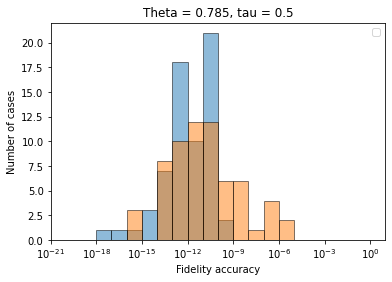

Theta =  0.8211482249970752
tau =  0.5357196087377883


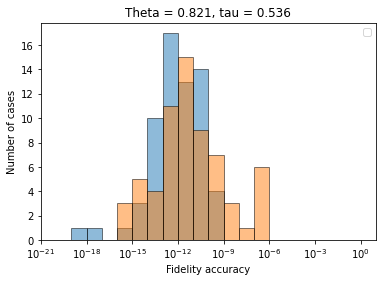

Theta =  0.8568982865967021
tau =  0.5712566870584256


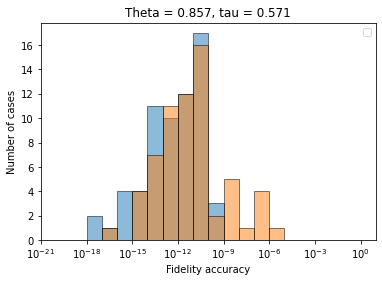

Theta =  0.892648348196329
tau =  0.6064296372916298


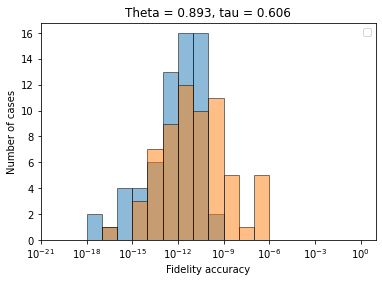

Theta =  0.9283984097959559
tau =  0.6410587224944339


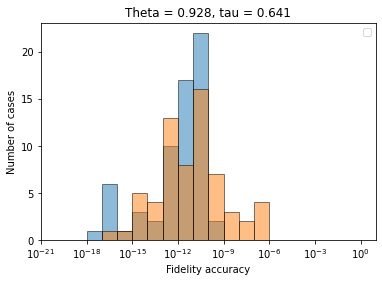

Theta =  0.9641484713955828
tau =  0.6749669849231511


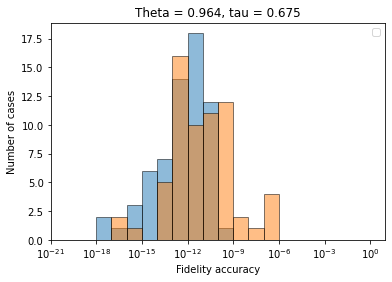

Theta =  0.9998985329952097
tau =  0.7079811503033792


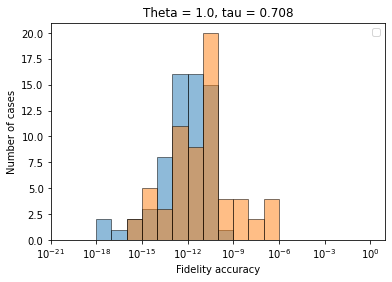

Theta =  1.0356485945948366
tau =  0.7399325132771458


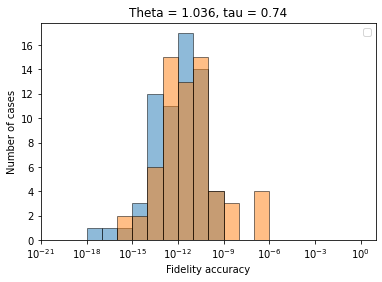

Theta =  1.0713986561944635
tau =  0.7706577995024795


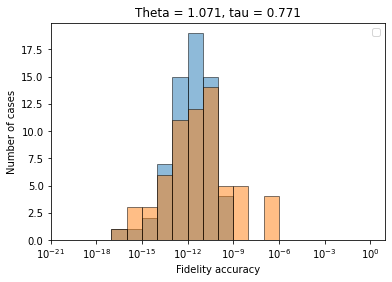

initial phis:
 [0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483]
Theta =  0.7853981633974483
tau =  0.5000000000000001


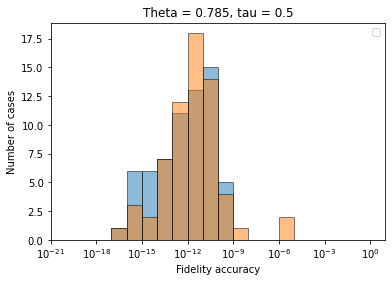

Theta =  0.8211482249970752
tau =  0.5357196087377883


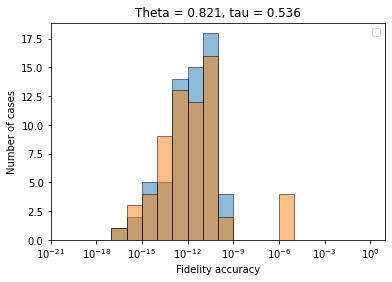

Theta =  0.8568982865967021
tau =  0.5712566870584256


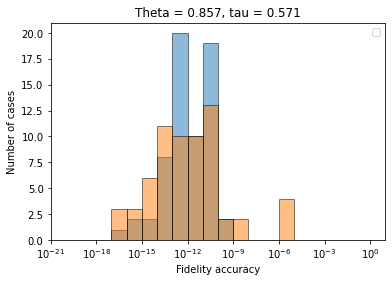

Theta =  0.892648348196329
tau =  0.6064296372916298


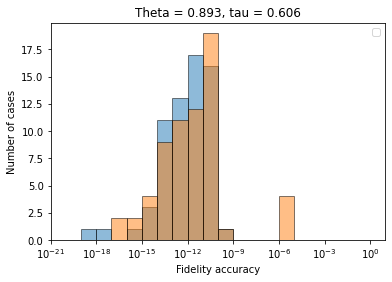

Theta =  0.9283984097959559
tau =  0.6410587224944339


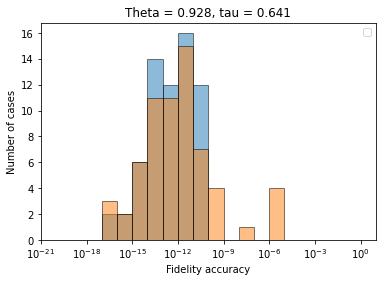

Theta =  0.9641484713955828
tau =  0.6749669849231511


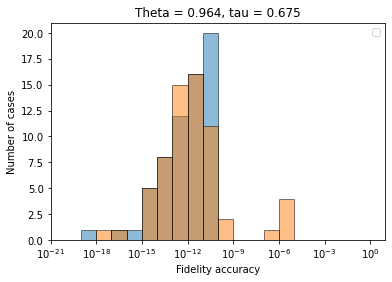

Theta =  0.9998985329952097
tau =  0.7079811503033792


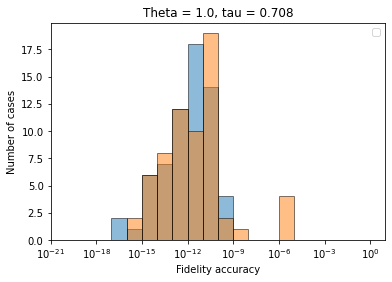

Theta =  1.0356485945948366
tau =  0.7399325132771458


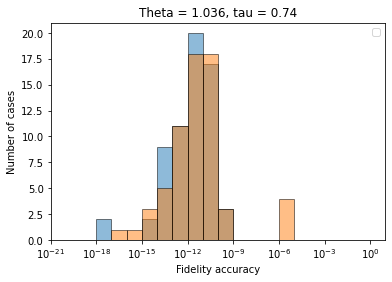

Theta =  1.0713986561944635
tau =  0.7706577995024795


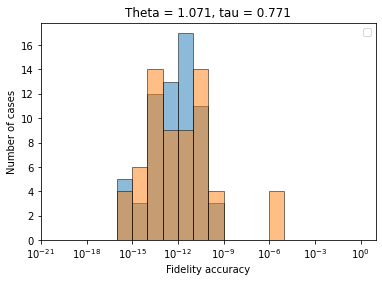

initial phis:
 [1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966]
Theta =  0.7853981633974483
tau =  0.5000000000000001


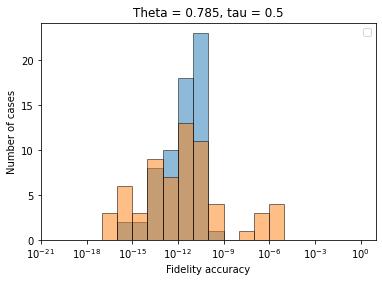

Theta =  0.8211482249970752
tau =  0.5357196087377883


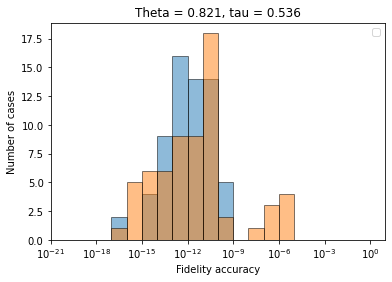

Theta =  0.8568982865967021
tau =  0.5712566870584256


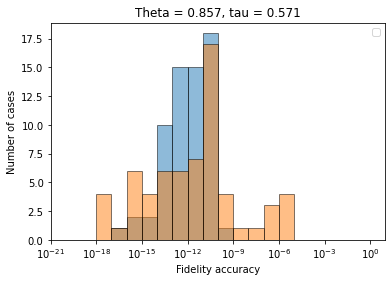

Theta =  0.892648348196329
tau =  0.6064296372916298


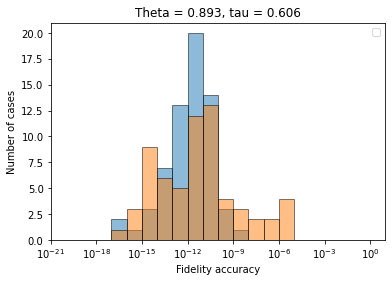

Theta =  0.9283984097959559
tau =  0.6410587224944339


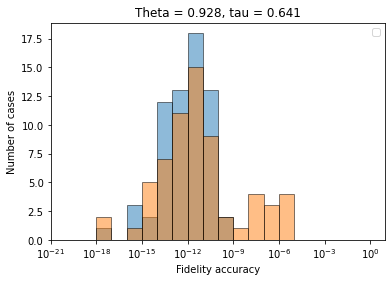

Theta =  0.9641484713955828
tau =  0.6749669849231511


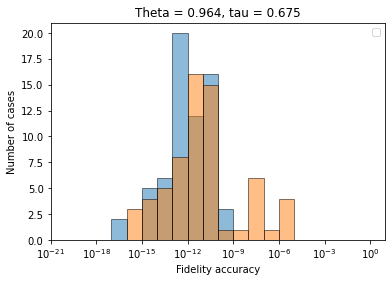

Theta =  0.9998985329952097
tau =  0.7079811503033792


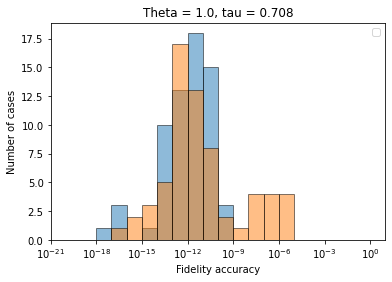

Theta =  1.0356485945948366
tau =  0.7399325132771458


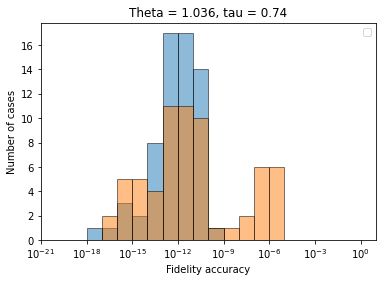

Theta =  1.0713986561944635
tau =  0.7706577995024795


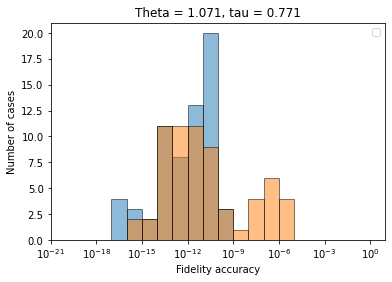

In [135]:
# input_vector = [0]*8
# output_vector = [0]*8
# input_vector = np.array([input_vector], dtype = complex).T #column
# output_vector = np.array([output_vector], dtype = complex).T #column
for j in range(len(x0)):
    print("initial phis:\n", x0[j])
    for i in range(len(Array_of_theta)):
        fidelities_ET = []
        fidelities_Cl = []
        print("Theta = ", Array_of_theta[i])
        tau = (math.sin(Array_of_theta[i]))**2
        print("tau = ", tau)
        for l in range(N):
            input_vector = np.array([0]*8, dtype = complex).T #column
            input_vector[l] = 1+1j # in_v = [0, ... , 1, ..., 0]
            for m in range(N):
                output_vector = np.array([0]*8, dtype = complex).T #column
                output_vector[m] = 1+1j # out_v = [0, ... , 1, ..., 0]
                # print("input_vector", input_vector)
                # print("output_vector", output_vector)
                res_ET = minimize(ET_fun, x0[j], args=(N, Array_of_theta[i], input_vector, output_vector, err), method='BFGS')
                res_Cl = minimize(Cl_fun, x0[j], args=(N, Array_of_theta[i], input_vector, output_vector, err), method='BFGS')
                
                phi_ET = phase_constraints(res_ET.x)
                # print("phis for ET [0, 2pi]:\n", np.round(phi_ET, 4))
                Fidelity_ET = ET_fun(res_ET.x, N, Array_of_theta[i], input_vector, output_vector, err)
                #print("Fidelity for ET:", Fidelity_ET)
                fidelities_ET.append(Fidelity_ET)

                phi_Cl = phase_constraints(res_Cl.x)
                # print("phis for Cl [0, 2pi]:\n", np.round(phi_Cl, 4))
                Fidelity_Cl = Cl_fun(res_Cl.x, N, Array_of_theta[i], input_vector, output_vector, err)
                #print("Fidelity for Clements:", Fidelity_Cl)
                fidelities_Cl.append(Fidelity_Cl)
                #print("-"*60)
        #print("="*80)        
        logbins = np.logspace(-20, 0, 21)
        plt.hist(fidelities_ET, bins = logbins, edgecolor='black', alpha = 0.5)
        plt.hist(fidelities_Cl, bins = logbins, edgecolor='black', alpha = 0.5) 
        plt.xscale('log')
        plt.title("Theta = {}, tau = {}".format(np.round(Array_of_theta[i], 3), np.round(tau, 3)))
        plt.xlabel("Fidelity accuracy")
        plt.ylabel("Number of cases")
        plt.legend("error-tolerant", "Clements")
        plt.savefig('{}.png'.format(i))
        plt.show()
        
        

        
        
        


In [152]:
random_i = np.array([random.random() for k in range(N)])
random_o = np.array([random.random() for k in range(N)])
random_i = random_i.T
random_o = random_o.T
print(random_i)
print(random_o)

[0.73261698 0.29490353 0.81215626 0.16839913 0.39274149 0.71951487
 0.95241465 0.45660099]
[0.69025045 0.05931579 0.61598911 0.54881258 0.05287597 0.02875763
 0.95744317 0.33217153]


# Random

initial phis:
 [0.0001, 0.39279908169872413, 0.7854981633974483, 1.1781972450961724, 1.5708963267948965, 1.9635954084936207, 2.356294490192345, 2.748993571891069, 3.1416926535897933, 3.5343917352885175, 3.9270908169872416, 4.319789898685965, 4.712488980384689, 5.105188062083414, 5.497887143782138, 5.890586225480861]
Theta =  0.7853981633974483
tau =  0.5000000000000001
--- 0.0 seconds after random vectors ---
--- 14.752346515655518 seconds after optimization ---
Fidelity for ET: 0.0035330590744601692
Fidelity for Clements: 0.017472028614178972
--- 0.0022530555725097656 seconds after fidelity ---
0
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 36.29888582229614 seconds after optimization ---
Fidelity for ET: 0.0021360655001680354
Fidelity for Clements: 0.006232693354831819
--- 0.0 seconds after fidelity ---
1
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 42.82908034324

--- 19.78008723258972 seconds after optimization ---
Fidelity for ET: 0.0011052967043968403
Fidelity for Clements: 0.00039658887995815394
--- 0.0 seconds after fidelity ---
27
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 15.469868183135986 seconds after optimization ---
Fidelity for ET: 0.032511362199238496
Fidelity for Clements: 0.07872885217900429
--- 0.00704503059387207 seconds after fidelity ---
28
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 14.843014240264893 seconds after optimization ---
Fidelity for ET: 0.00557468402695584
Fidelity for Clements: 0.031143249819222497
--- 0.008117198944091797 seconds after fidelity ---
29
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 24.834340810775757 seconds after optimization ---
Fidelity for ET: 0.08887242397867848
Fidelity for Clements: 0.10365813926176148
--- 0

--- 28.59965753555298 seconds after optimization ---
Fidelity for ET: 0.006390146859941418
Fidelity for Clements: 0.007191365144978691
--- 0.0 seconds after fidelity ---
56
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 39.520081758499146 seconds after optimization ---
Fidelity for ET: 0.02357725076688781
Fidelity for Clements: 0.020288935391313843
--- 0.007876157760620117 seconds after fidelity ---
57
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 47.01214146614075 seconds after optimization ---
Fidelity for ET: 0.01874968463934387
Fidelity for Clements: 0.020044715371487873
--- 0.008286237716674805 seconds after fidelity ---
58
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 57.56981706619263 seconds after optimization ---
Fidelity for ET: 0.006771299646402179
Fidelity for Clements: 0.01677204574954439
--- 0.0 

C:\Users\79998\AppData\Local\Temp\ipykernel_11304\55570630.py:50: UserWarning: Legend does not support 'e' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local\Temp\ipykernel_11304\55570630.py:50: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local\Temp\ipykernel_11304\55570630.py:50: UserWarning: Legend does not support 'o' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local\Temp\

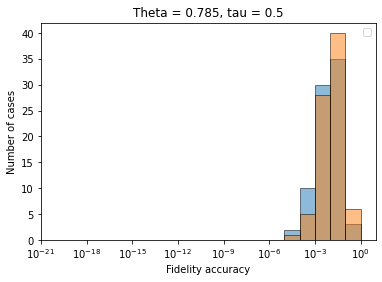

Theta =  0.8211482249970752
tau =  0.5357196087377883
--- 0.0 seconds after random vectors ---
--- 13.844578266143799 seconds after optimization ---
Fidelity for ET: 0.03176389915854699
Fidelity for Clements: 0.11831984938963734
--- 0.015622377395629883 seconds after fidelity ---
0
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 19.94357466697693 seconds after optimization ---
Fidelity for ET: 0.029380198383179415
Fidelity for Clements: 0.05714390426281359
--- 0.015575885772705078 seconds after fidelity ---
1
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 35.22844743728638 seconds after optimization ---
Fidelity for ET: 0.03650063086786372
Fidelity for Clements: 0.05099167904380458
--- 0.0 seconds after fidelity ---
2
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 10.823012590408325 seconds after optimization ---

--- 14.685768127441406 seconds after optimization ---
Fidelity for ET: 0.010807894585352248
Fidelity for Clements: 0.09863606141416488
--- 0.0 seconds after fidelity ---
29
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 24.584619283676147 seconds after optimization ---
Fidelity for ET: 0.0016182410499972055
Fidelity for Clements: 0.011901639728216949
--- 0.0 seconds after fidelity ---
30
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 32.2924370765686 seconds after optimization ---
Fidelity for ET: 0.015562900914004401
Fidelity for Clements: 0.03927068353891906
--- 0.0 seconds after fidelity ---
31
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 43.94800567626953 seconds after optimization ---
Fidelity for ET: 0.0005712977563496432
Fidelity for Clements: 0.003913066160663721
--- 0.0 seconds after fidelity ---
32
-

--- 21.19773030281067 seconds after optimization ---
Fidelity for ET: 0.06596880057160583
Fidelity for Clements: 0.06184380953583058
--- 0.0 seconds after fidelity ---
59
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 63.97649025917053 seconds after optimization ---
Fidelity for ET: 0.0007044307721524048
Fidelity for Clements: 0.006473930966971561
--- 0.0 seconds after fidelity ---
60
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 26.633196592330933 seconds after optimization ---
Fidelity for ET: 0.006372915147781788
Fidelity for Clements: 0.003804638591233388
--- 0.0 seconds after fidelity ---
61
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 30.573044776916504 seconds after optimization ---
Fidelity for ET: 0.000558272492445847
Fidelity for Clements: 0.015251448819903316
--- 0.0 seconds after fidelity ---
62
-

C:\Users\79998\AppData\Local\Temp\ipykernel_11304\55570630.py:50: UserWarning: Legend does not support 'e' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local\Temp\ipykernel_11304\55570630.py:50: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local\Temp\ipykernel_11304\55570630.py:50: UserWarning: Legend does not support 'o' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local\Temp\

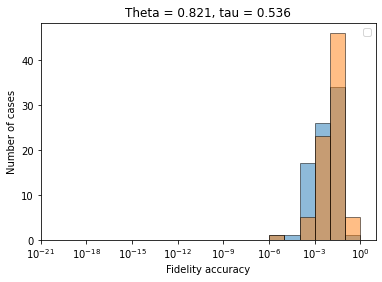

Theta =  0.8568982865967021
tau =  0.5712566870584256
--- 0.0 seconds after random vectors ---
--- 22.728676557540894 seconds after optimization ---
Fidelity for ET: 0.00027617774044835845
Fidelity for Clements: 0.00047610381047207874
--- 0.0 seconds after fidelity ---
0
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 25.525672435760498 seconds after optimization ---
Fidelity for ET: 0.0004482336955967693
Fidelity for Clements: 0.00044823851114002695
--- 0.0 seconds after fidelity ---
1
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 35.86053514480591 seconds after optimization ---
Fidelity for ET: 0.01081746897680552
Fidelity for Clements: 0.022584705614879706
--- 0.0 seconds after fidelity ---
2
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 33.6643750667572 seconds after optimization ---
Fidelity for ET: 0.0098

--- 12.802186489105225 seconds after optimization ---
Fidelity for ET: 0.016931682917789254
Fidelity for Clements: 0.03228852844608752
--- 0.015626907348632812 seconds after fidelity ---
30
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 64.54900622367859 seconds after optimization ---
Fidelity for ET: 0.00764725694381031
Fidelity for Clements: 0.020116373481313614
--- 0.0 seconds after fidelity ---
31
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 34.20707416534424 seconds after optimization ---
Fidelity for ET: 0.0012297343623279867
Fidelity for Clements: 0.0017390339601020888
--- 0.0 seconds after fidelity ---
32
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 43.96784567832947 seconds after optimization ---
Fidelity for ET: 0.00017360999588084637
Fidelity for Clements: 0.006601516085943245
--- 0.0 seconds afte

--- 49.12657713890076 seconds after optimization ---
Fidelity for ET: 0.049799064474528684
Fidelity for Clements: 0.06906589694329678
--- 0.0020084381103515625 seconds after fidelity ---
60
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 44.53001046180725 seconds after optimization ---
Fidelity for ET: 0.017714643118766544
Fidelity for Clements: 0.016094985222363106
--- 0.0 seconds after fidelity ---
61
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 48.100130796432495 seconds after optimization ---
Fidelity for ET: 0.01274981434615801
Fidelity for Clements: 0.014671890385588192
--- 0.008083105087280273 seconds after fidelity ---
62
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 49.66362762451172 seconds after optimization ---
Fidelity for ET: 0.007312616354395638
Fidelity for Clements: 0.011704785307694953
--- 0.

C:\Users\79998\AppData\Local\Temp\ipykernel_11304\55570630.py:50: UserWarning: Legend does not support 'e' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local\Temp\ipykernel_11304\55570630.py:50: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local\Temp\ipykernel_11304\55570630.py:50: UserWarning: Legend does not support 'o' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local\Temp\

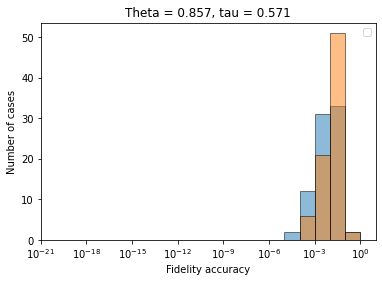

Theta =  0.892648348196329
tau =  0.6064296372916298
--- 0.0 seconds after random vectors ---


KeyboardInterrupt: 

In [154]:
for j in range(len(x0)):
    print("initial phis:\n", x0[j])
    for i in range(len(Array_of_theta)):
        fidelities_ET = []
        fidelities_Cl = [] 
        print("Theta = ", Array_of_theta[i])
        tau = (math.sin(Array_of_theta[i]))**2
        print("tau = ", tau)
        for l in range(80):
            start_time = time.time()
            random_input_vector = []
            random_iv = []
            random_output_vector = []
            random_ov = []
            random_input_vector = np.array([random.random() for k in range(N)]).T
            random_iv = normalized_vector(random_input_vector)
            random_output_vector = np.array([random.random() for k in range(N)]).T
            random_ov = normalized_vector(random_output_vector)
            #random_iv = np.array([random_iv]).T #column
            #random_ov = np.array([random_ov]).T #column
            print("--- %s seconds after random vectors ---" % (time.time() - start_time))
            time1 = time.time()
            res_ET = minimize(ET_fun, x0[j], args=(N, Array_of_theta[i], random_iv, random_ov, err), method='BFGS')
            res_Cl = minimize(Cl_fun, x0[j], args=(N, Array_of_theta[i], random_iv, random_ov, err), method='BFGS')
            
            print("--- %s seconds after optimization ---" % (time.time() - time1)) 
            phi_ET = phase_constraints(res_ET.x)
            #print("phis for ET [0, 2pi]:\n", np.round(phi_ET, 4))
            time2 = time.time()
            Fidelity_ET = ET_fun(res_ET.x, N, Array_of_theta[i], random_iv, random_ov, err)
            print("Fidelity for ET:", Fidelity_ET)
            fidelities_ET.append(Fidelity_ET)

            phi_Cl = phase_constraints(res_Cl.x)
            # print("phis for Cl [0, 2pi]:\n", np.round(phi_Cl, 4))
            Fidelity_Cl = Cl_fun(res_Cl.x, N, Array_of_theta[i], random_iv, random_ov, err)
            print("Fidelity for Clements:", Fidelity_Cl)
            fidelities_Cl.append(Fidelity_Cl)
            print("--- %s seconds after fidelity ---" % (time.time() - time2))
            print(l)
            print("-"*60)
        print("="*80)        
        logbins = np.logspace(-20, 0, 21)
        plt.hist(fidelities_ET, bins = logbins, edgecolor='black', alpha = 0.5)
        plt.hist(fidelities_Cl, bins = logbins, edgecolor='black', alpha = 0.5) 
        plt.xscale('log')
        plt.title("Theta = {}, tau = {}".format(np.round(Array_of_theta[i], 3), np.round(tau, 3)))
        plt.xlabel("Fidelity accuracy")
        plt.ylabel("Number of cases")
        plt.legend("error-tolerant", "Clements")
        plt.show()



Theta =  0.7853981633974483
tau =  0.5000000000000001
--- 0.0 seconds after random vectors ---
--- 49.669708490371704 seconds after optimization ---
Fidelity for ET: 0.005748864033384918
Fidelity for Clements: 0.009962355192324242
--- 0.003399372100830078 seconds after fidelity ---
0
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 39.81005930900574 seconds after optimization ---
Fidelity for ET: 0.003968394992894742
Fidelity for Clements: 0.059578017584670684
--- 0.0 seconds after fidelity ---
1
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 42.41813898086548 seconds after optimization ---
Fidelity for ET: 0.08624762705946423
Fidelity for Clements: 0.049513269977483176
--- 0.0020089149475097656 seconds after fidelity ---
2
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 19.449068069458008 seconds after optimizatio

--- 21.04562473297119 seconds after optimization ---
Fidelity for ET: 0.003411514141007632
Fidelity for Clements: 0.0030919247070075656
--- 0.001565694808959961 seconds after fidelity ---
29
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 30.9498553276062 seconds after optimization ---
Fidelity for ET: 0.0005511585672254972
Fidelity for Clements: 0.022314014616326126
--- 0.0 seconds after fidelity ---
30
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 43.75001573562622 seconds after optimization ---
Fidelity for ET: 0.007395639735027241
Fidelity for Clements: 0.009711540338265755
--- 0.0 seconds after fidelity ---
31
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 16.826582431793213 seconds after optimization ---
Fidelity for ET: 0.01617528528803677
Fidelity for Clements: 0.016742976324244815
--- 0.0034239292144775

--- 54.098552227020264 seconds after optimization ---
Fidelity for ET: 0.004879823054562009
Fidelity for Clements: 0.0049584036094201265
--- 0.002010822296142578 seconds after fidelity ---
58
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 16.90549921989441 seconds after optimization ---
Fidelity for ET: 0.0061873100985070165
Fidelity for Clements: 0.005068453904652224
--- 0.008031129837036133 seconds after fidelity ---
59
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 21.725128173828125 seconds after optimization ---
Fidelity for ET: 0.06728504554656081
Fidelity for Clements: 0.10827002423407639
--- 0.01102590560913086 seconds after fidelity ---
60
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 34.76293873786926 seconds after optimization ---
Fidelity for ET: 0.007383221049643354
Fidelity for Clements: 0.0071239

--- 30.712589502334595 seconds after optimization ---
Fidelity for ET: 0.012106699701822314
Fidelity for Clements: 0.009664259619266612
--- 0.0029611587524414062 seconds after fidelity ---
87
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 22.93074369430542 seconds after optimization ---
Fidelity for ET: 0.0027445011830842855
Fidelity for Clements: 0.0023272206170488093
--- 0.002958536148071289 seconds after fidelity ---
88
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 29.650944232940674 seconds after optimization ---
Fidelity for ET: 0.069791266073906
Fidelity for Clements: 0.11058916616852318
--- 0.0037543773651123047 seconds after fidelity ---
89
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 74.19315218925476 seconds after optimization ---
Fidelity for ET: 0.0007142179021028725
Fidelity for Clements: 9.31450

C:\Users\79998\AppData\Local\Temp\ipykernel_11304\358994827.py:48: UserWarning: Legend does not support 'e' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local\Temp\ipykernel_11304\358994827.py:48: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local\Temp\ipykernel_11304\358994827.py:48: UserWarning: Legend does not support 'o' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local\Te

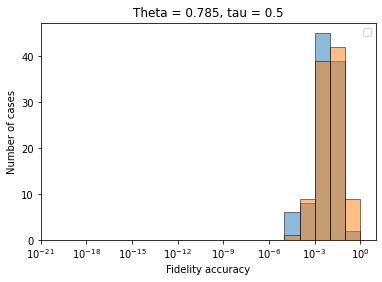

Theta =  0.892648348196329
tau =  0.6064296372916298
--- 0.0 seconds after random vectors ---
--- 24.710511684417725 seconds after optimization ---
Fidelity for ET: 0.00218554109257254
Fidelity for Clements: 0.005310427048395632
--- 0.003985881805419922 seconds after fidelity ---
0
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 71.7322940826416 seconds after optimization ---
Fidelity for ET: 0.012849316699913047
Fidelity for Clements: 0.09029066066401036
--- 0.0029633045196533203 seconds after fidelity ---
1
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 49.780221700668335 seconds after optimization ---
Fidelity for ET: 0.009522216155428346
Fidelity for Clements: 0.009522279868180186
--- 0.0039865970611572266 seconds after fidelity ---
2
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 35.21558451652527 seconds af

--- 11.96586298942566 seconds after optimization ---
Fidelity for ET: 0.04348413869056369
Fidelity for Clements: 0.20255128787411472
--- 0.0 seconds after fidelity ---
29
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 52.95234394073486 seconds after optimization ---
Fidelity for ET: 0.08868771009567757
Fidelity for Clements: 0.10856821121291488
--- 0.0039768218994140625 seconds after fidelity ---
30
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 82.78175377845764 seconds after optimization ---
Fidelity for ET: 0.03175784990679168
Fidelity for Clements: 0.04642125440710223
--- 0.003985881805419922 seconds after fidelity ---
31
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 47.30322885513306 seconds after optimization ---
Fidelity for ET: 0.011245031655993266
Fidelity for Clements: 0.003055712625764771
--- 0.00495

--- 27.439067363739014 seconds after optimization ---
Fidelity for ET: 0.00015112969268253303
Fidelity for Clements: 0.00010765478934087583
--- 0.0 seconds after fidelity ---
59
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 31.648555040359497 seconds after optimization ---
Fidelity for ET: 0.0019275043579288483
Fidelity for Clements: 0.05604032991722607
--- 0.015623092651367188 seconds after fidelity ---
60
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 44.08043050765991 seconds after optimization ---
Fidelity for ET: 3.4955814098505962e-06
Fidelity for Clements: 0.001204040061541736
--- 0.0 seconds after fidelity ---
61
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 25.898900747299194 seconds after optimization ---
Fidelity for ET: 0.0017807681937832176
Fidelity for Clements: 0.0004070183840459658
--- 0.0 seco

--- 66.1512291431427 seconds after optimization ---
Fidelity for ET: 0.010074343064359144
Fidelity for Clements: 0.0018651962964511156
--- 0.002984285354614258 seconds after fidelity ---
88
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 62.4594292640686 seconds after optimization ---
Fidelity for ET: 0.002353807107383354
Fidelity for Clements: 0.002078233282036336
--- 0.001993894577026367 seconds after fidelity ---
89
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 41.4351806640625 seconds after optimization ---
Fidelity for ET: 0.00023994022995641812
Fidelity for Clements: 0.0002394584333326423
--- 0.002991199493408203 seconds after fidelity ---
90
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 26.60403299331665 seconds after optimization ---
Fidelity for ET: 0.00040489427671150326
Fidelity for Clements: 0.00790

C:\Users\79998\AppData\Local\Temp\ipykernel_11304\358994827.py:48: UserWarning: Legend does not support 'e' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local\Temp\ipykernel_11304\358994827.py:48: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local\Temp\ipykernel_11304\358994827.py:48: UserWarning: Legend does not support 'o' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("error-tolerant", "Clements")
C:\Users\79998\AppData\Local\Te

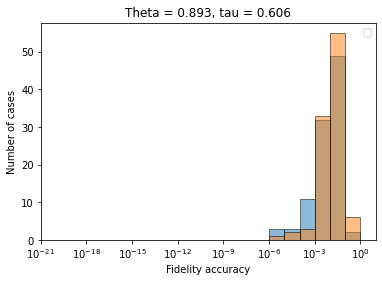

Theta =  0.9998985329952097
tau =  0.7079811503033792
--- 0.0 seconds after random vectors ---
--- 60.30830478668213 seconds after optimization ---
Fidelity for ET: 0.012388824624948917
Fidelity for Clements: 0.1391719799466771
--- 0.003985166549682617 seconds after fidelity ---
0
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 38.801899433135986 seconds after optimization ---
Fidelity for ET: 0.00037379448235102863
Fidelity for Clements: 0.005831727691380392
--- 0.003986358642578125 seconds after fidelity ---
1
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 31.710233688354492 seconds after optimization ---
Fidelity for ET: 0.0016103478406255154
Fidelity for Clements: 0.0019967132671453816
--- 0.002990245819091797 seconds after fidelity ---
2
------------------------------------------------------------
--- 0.0 seconds after random vectors ---
--- 16.824098110198975 secon

KeyboardInterrupt: 

In [155]:
Array_of_theta_ran = Theta_0_5_0_8(3)
time_start = time.time()
for i in range(len(Array_of_theta_ran)):
    fidelities_ET = []
    fidelities_Cl = [] 
    print("Theta = ", Array_of_theta_ran[i])
    tau = (math.sin(Array_of_theta_ran[i]))**2
    print("tau = ", tau)
    for l in range(100):
        time0 = time.time()
        random_input_vector = []
        random_iv = []
        random_output_vector = []
        random_ov = []
        random_input_vector = np.array([random.random() for k in range(N)]).T
        random_iv = normalized_vector(random_input_vector)
        random_output_vector = np.array([random.random() for k in range(N)]).T
        random_ov = normalized_vector(random_output_vector)
        print("--- %s seconds after random vectors ---" % (time.time() - time0))
        time1 = time.time()
        res_ET = minimize(ET_fun, x0[0], args=(N, Array_of_theta_ran[i], random_iv, random_ov, err), method='BFGS')
        res_Cl = minimize(Cl_fun, x0[0], args=(N, Array_of_theta_ran[i], random_iv, random_ov, err), method='BFGS')
            
        print("--- %s seconds after optimization ---" % (time.time() - time1)) 
        phi_ET = phase_constraints(res_ET.x)
        #print("phis for ET [0, 2pi]:\n", np.round(phi_ET, 4))
        time2 = time.time()
        Fidelity_ET = ET_fun(res_ET.x, N, Array_of_theta_ran[i], random_iv, random_ov, err)
        print("Fidelity for ET:", Fidelity_ET)
        fidelities_ET.append(Fidelity_ET)

        phi_Cl = phase_constraints(res_Cl.x)
        # print("phis for Cl [0, 2pi]:\n", np.round(phi_Cl, 4))
        Fidelity_Cl = Cl_fun(res_Cl.x, N, Array_of_theta_ran[i], random_iv, random_ov, err)
        print("Fidelity for Clements:", Fidelity_Cl)
        fidelities_Cl.append(Fidelity_Cl)
        print("--- %s seconds after fidelity ---" % (time.time() - time2))
        print(l)
        print("-"*60)
    print("="*80)        
    logbins = np.logspace(-20, 0, 21)
    plt.hist(fidelities_ET, bins = logbins, edgecolor='black', alpha = 0.5)
    plt.hist(fidelities_Cl, bins = logbins, edgecolor='black', alpha = 0.5) 
    plt.xscale('log')
    plt.title("Theta = {}, tau = {}".format(np.round(Array_of_theta_ran[i], 3), np.round(tau, 3)))
    plt.xlabel("Fidelity accuracy")
    plt.ylabel("Number of cases")
    plt.legend("error-tolerant", "Clements")
    plt.show()
print(time.time() - time_start)


# Uniform

In [ ]:
# uniform_iv = [1, 1, 1, 1, 0, 0, 0, 0]
# uniform_iv = normalized_vector(uniform_iv)
# uniform_ov = [0, 0, 0, 0, 1, 1, 1, 1]
# uniform_ov = normalized_vector(uniform_ov)
# uniform_iv = np.array([uniform_iv]).T #column
# uniform_ov = np.array([uniform_ov]).T #column

for j in range(len(x0)):
    print("initial phis:\n", x0[j])
    for i in range(len(Array_of_theta)):
        fidelities_ET = []
        fidelities_Cl = []
        print("Theta = ", Array_of_theta[i])
        tau = (math.sin(Array_of_theta[i]))**2
        print("tau = ", tau)
        for l in range(N):
            input_vector = np.array([0]*8, dtype = complex).T #column
            input_vector[l] = 1+1j # in_v = [0, ... , 1, ..., 0]
            for m in range(N):
                output_vector = np.array([0]*8, dtype = complex).T #column
                output_vector[m] = 1+1j # out_v = [0, ... , 1, ..., 0]
                # print("input_vector", input_vector)
                # print("output_vector", output_vector)
                res_ET = minimize(ET_fun, x0[j], args=(N, Array_of_theta[i], input_vector, output_vector, err), method='BFGS')
                res_Cl = minimize(Cl_fun, x0[j], args=(N, Array_of_theta[i], input_vector, output_vector, err), method='BFGS')
                
                phi_ET = phase_constraints(res_ET.x)
                # print("phis for ET [0, 2pi]:\n", np.round(phi_ET, 4))
                Fidelity_ET = ET_fun(res_ET.x, N, Array_of_theta[i], input_vector, output_vector, err)
                #print("Fidelity for ET:", Fidelity_ET)
                fidelities_ET.append(Fidelity_ET)

                phi_Cl = phase_constraints(res_Cl.x)
                # print("phis for Cl [0, 2pi]:\n", np.round(phi_Cl, 4))
                Fidelity_Cl = Cl_fun(res_Cl.x, N, Array_of_theta[i], input_vector, output_vector, err)
                #print("Fidelity for Clements:", Fidelity_Cl)
                fidelities_Cl.append(Fidelity_Cl)
                #print("-"*60)
        #print("="*80)        
        logbins = np.logspace(-20, 0, 21)
        plt.hist(fidelities_ET, bins = logbins, edgecolor='black', alpha = 0.5)
        plt.hist(fidelities_Cl, bins = logbins, edgecolor='black', alpha = 0.5) 
        plt.xscale('log')
        plt.title("Theta = {}, tau = {}".format(np.round(Array_of_theta[i], 3), np.round(tau, 3)))
        plt.xlabel("Fidelity accuracy")
        plt.ylabel("Number of cases")
        plt.legend("error-tolerant", "Clements")
        plt.savefig('{}.png'.format(i))
        plt.show()